#DATASCI W261: Machine Learning at Scale - Week 9 - Homework 9
##Hussein Danish (hdanish@ischool.berkeley.edu)
## 12/03/2016

In [1]:
#Use this to make sure we reload the MrJob code when we make changes
%load_ext autoreload
%autoreload 2

###===HW 9.0: Short answer questions===

*What is PageRank and what is it used for in the context of web search?*

PageRank is an algorithm that operates on network graphs by assigning a score to each node of the graph in order to determine their importance. It was named after Larry Page. PageRank is used by Google Search to rank websites in their search engine results. It measures the importance of web pages. Currently, it is not the only algorithm that is used in web search but at Google it was the first and it is the most well known algorithm.

*What modifications have to be made to the webgraph in order to leverage the machinery of Markov Chains to 
compute the steady stade distibuton?*

When leveraging the machinery of Markov Chains, pages are viewed as states and the webgraph is viewed as a transition matrix. The modifications required for this are two-fold:

1. Stochasticity adjustment
  * This adjustment is made in order to deal with dangling nodes. In order for a matrix to be stochastic, the rows must sum up to 1. Therefore, instead of using 1 to indicate a transition, a value 1/n is used where n represents the non-zero elements of a row. This adjustment now allows the random surfer to hyperlink to any page randomely after entering a dangling node. From this we now have a stochastic transition matrix H.
2. Primitivity adjustment
  * This adjustment can be thought of as the random surfer getting bored with following the hyperlink structure and sometimes going to an entirely new URL and continuing from there. To achieve this, a damping factor (alpha) is introduced. This is a value between 0 and 1 and represents the probability of making a random jump. To achieve our final stochastic transition probability matrix P, we multiply H by (1-alpha) and add to it a teleportation matrix I(1/n) which is multiplied by alpha. Here, n represents the number of nodes in the graph.
  
After our adjustments we thus have P = (1-alpha) H + alpha I(1/n).

###===HW 9.1: MRJob implementation of basic PageRank===

Using modified files from HW7 for exploratory analysis.

In [10]:
%%writefile mrexplorenltk.py

from mrjob.job import MRJob
from mrjob.job import MRStep
import csv
from operator import itemgetter
import re
import ast

class mrExploreNLTKTotals(MRJob):
            
    def mapper(self, _, line):
        """Emit keyless records (since we don't want to group our results)
        Values are (1,node_degree)"""
        line = line.strip('\n')
        data = line.split("\t")
        nid = data[0]
        N = eval(data[1])
        node_degree = len(N)
        for n in N.iteritems():
            yield _,(n[0],n[1])
        yield _,(nid,0)

        
    def reducer(self, _, line):
        """Aggregate node counts and degree counts"""
        nodes=set()
        edges=0
        for record in line:
            nodes.add(record[0])
            edges+=record[1]    
        yield None, (len(nodes),edges)
    
    def steps(self):
        return [MRStep(  mapper=self.mapper
                    ,reducer=self.reducer
                )
            ]
                
if __name__ == '__main__':
    mrExploreNLTKTotals.run()

Overwriting mrexplorenltk.py


In [11]:
#HW 7.1 - Calculating summary stats on NLTK data locally
%reload_ext autoreload
%autoreload 2
from __future__ import division
from mrexplorenltk import mrExploreNLTKTotals

mr_job = mrExploreNLTKTotals(args=['PageRank-test.txt','--no-strict-protocols'])
nodes=0
edges=0
with mr_job.make_runner() as runner:
    runner.run()
    for line in runner.stream_output():
        #This performs the same function as the reducer, which is needed to calculate the
        #final totals across a larger cluster.  It's not really important for local use, 
        #but we'll need it for EMR
        _,count =  mr_job.parse_output_line(line)
        nodes+=count[0]
        edges+=count[1]

print "Total Nodes = {}".format(nodes)   
print "Total Edges = {}".format(edges)   
print "Average Edges/Node = {}".format(edges/nodes)

Total Nodes = 11
Total Edges = 17
Average Edges/Node = 1.54545454545


Now we know that this graph we are working with has 11 nodes

In [80]:
%%writefile MRpageRank.py

from mrjob.job import MRJob
from mrjob.job import MRStep
import ast

class MRpageRank(MRJob):
    
    def configure_options(self):
        super(MRpageRank, self).configure_options()
        
        self.add_passthrough_option('--iterations', default=10, type=int,
                                    help='number of iterations to compute stable pagerank')
        self.add_passthrough_option('--d', default=0.85, type=float,
                                    help='dampening factor')
        self.add_passthrough_option('--N', default=None, type=int,
                                    help='total number of nodes')
    
    def init(self, _, line):
        line = line.strip('\n')
        nid, nodes = line.split('\t')
        p = 1/float(self.options.N)
        yield nid, nodes+"|"+str(p)
    
    def mapper(self, nid, nodes_score):
        nodes, score = map(ast.literal_eval, nodes_score.split('|'))
        
        yield nid, ('node', nodes) # pass along graph structure
        
        for n, w in nodes.iteritems():
            yield n, ('score', score*w/len(nodes))        
            
    def reducer(self, nid, values):
        nodes={}
        total_score = 0
        
        for typ, value in values:
            if typ == 'node':
                nodes = value
            elif typ == 'score':
                total_score += value
                
        N = self.options.N
        d = self.options.d
        
        score = (1-d)/float(N) + d*float(total_score)
        
        yield nid, str(nodes)+"|"+str(score)
            
    def steps(self):
        return (
                [MRStep(mapper = self.init)] +
                [MRStep(mapper = self.mapper,
                       reducer = self.reducer)] * self.options.iterations
        )
    
if __name__ == '__main__':
    MRpageRank.run()

Overwriting MRpageRank.py


In [81]:
!python MRpageRank.py PageRank-test.txt --N=11 -q

"A"	"{}|0.0276465093104"
"B"	"{'C': 1}|0.303619181848"
"C"	"{'B': 1}|0.309729572333"
"D"	"{'A': 1, 'B': 1}|0.0329788585778"
"E"	"{'B': 1, 'D': 1, 'F': 1}|0.0682146911287"
"F"	"{'B': 1, 'E': 1}|0.0329788585778"
"G"	"{'B': 1, 'E': 1}|0.0136363636364"
"H"	"{'B': 1, 'E': 1}|0.0136363636364"
"I"	"{'B': 1, 'E': 1}|0.0136363636364"
"J"	"{'E': 1}|0.0136363636364"
"K"	"{'E': 1}|0.0136363636364"


###===HW 9.2: Exploring PageRank teleportation and network plots===

In [100]:
# First we will produce different files to use as input for the graphs
!python MRpageRank.py PageRank-test.txt --N=11 --d=0 -q > 92d0.txt
!python MRpageRank.py PageRank-test.txt --N=11 --d=0.25 -q > 92d0.25.txt
!python MRpageRank.py PageRank-test.txt --N=11 --d=0.5 -q > 92d0.5.txt
!python MRpageRank.py PageRank-test.txt --N=11 --d=0.75 -q > 92d0.75.txt
!python MRpageRank.py PageRank-test.txt --N=11 --d=0.85 -q > 92d0.85.txt
!python MRpageRank.py PageRank-test.txt --N=11 --d=1 -q > 92d1.txt

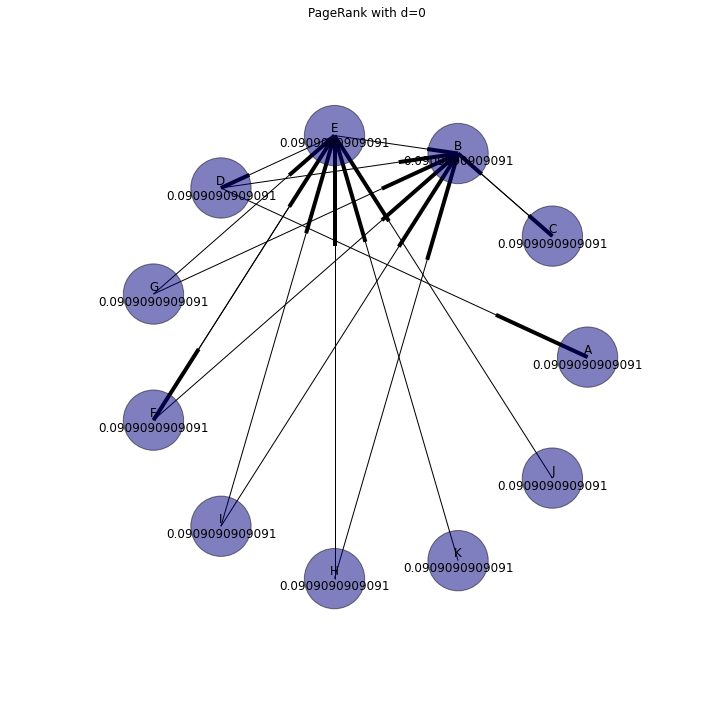

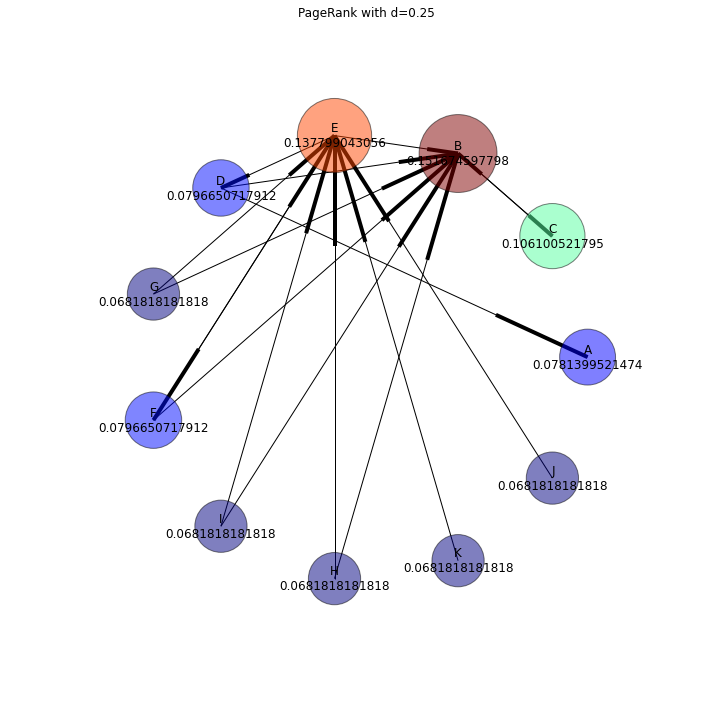

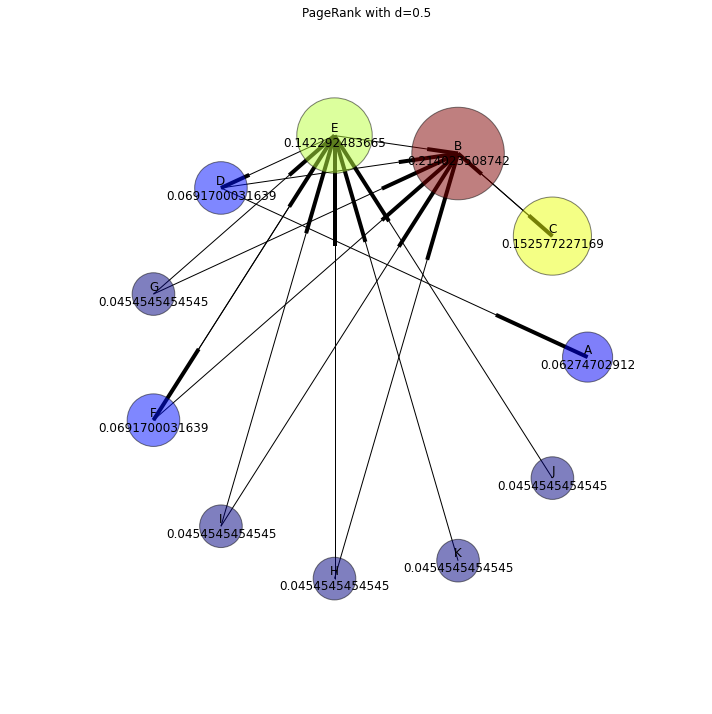

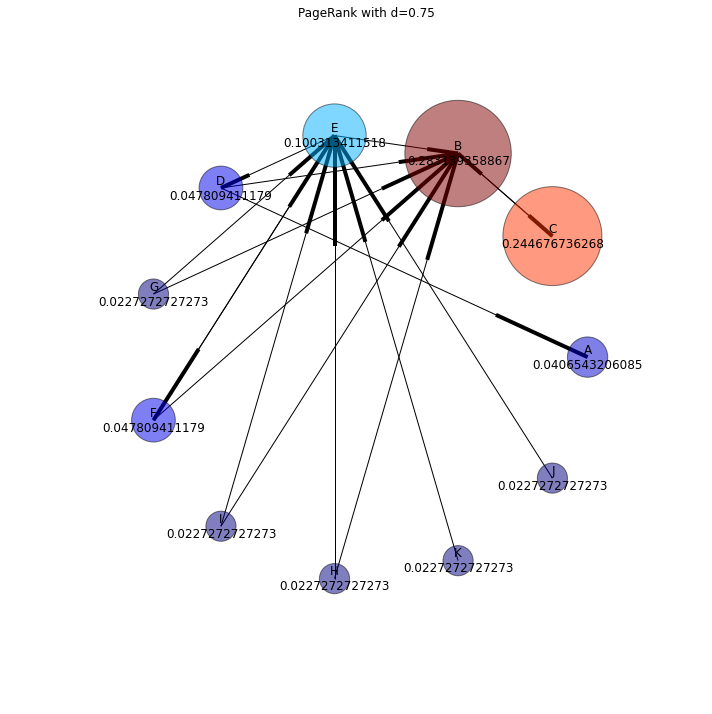

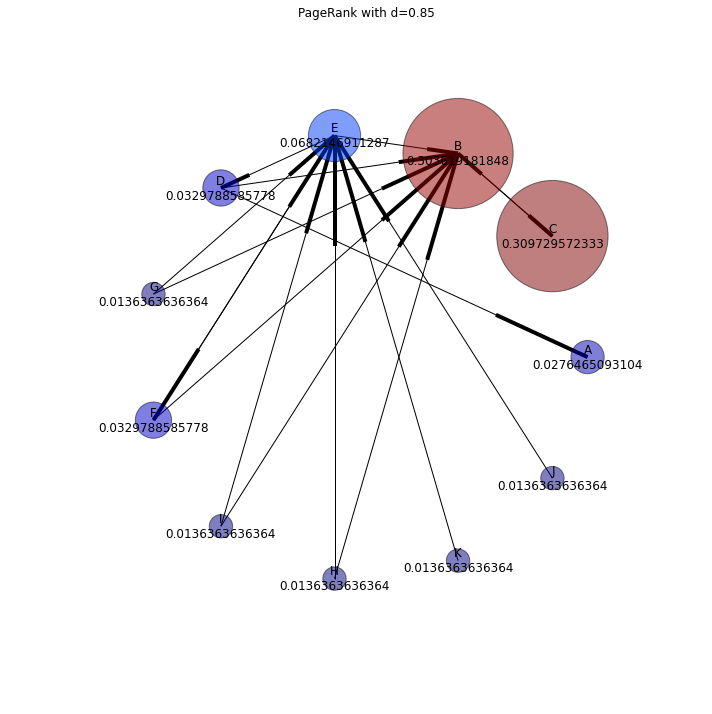

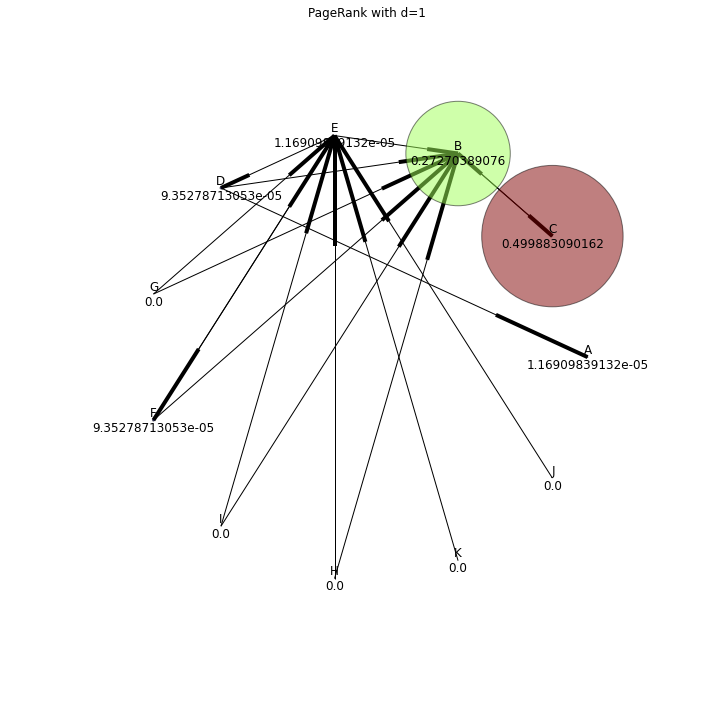

In [140]:
%matplotlib inline
import networkx as nx
import ast
from matplotlib import pyplot as plt

# Draw graphs
def draw(edges, scores, d):
    plt.figure(figsize=(10, 10))

    # initialize directed graph
    DG = nx.DiGraph()

    # add edges
    for edge in edges:
        DG.add_edge(edge[0], edge[1])    
    
    node_size = [scores[n]*40000 for n in DG.nodes()]

    graph_pos = nx.circular_layout(DG)

    # set labels
    labels = {}    
    for node in DG.nodes():
        labels[node] = '{}\n{}'.format(node, scores[node])

    # draw graph
    nx.draw_networkx_nodes(DG, graph_pos, node_size = node_size, node_color=node_size, alpha = 0.5)
    nx.draw_networkx_edges(DG, graph_pos, edge_color = 'black', arrows = True)
    nx.draw_networkx_labels(DG, graph_pos, labels=labels, font_size = 12)

    # show graph
    plt.title("PageRank with d={}".format(d))
    plt.axis('off')
    plt.tight_layout()
    plt.show()    

# Take filename, damping factor as input to produce plots by drawing graphs
def plot(f, d):
    edges = []
    scores = {}
    
    for line in open(f).read().strip().split('\n'):
        nid, nodes_score = line.split('\t') # Parse the line into the main node id and the nodes_score string
        
        nid = nid.replace('"', '') # Remove double quotes from node name
        
        nodes, score = map(ast.literal_eval, nodes_score.strip('"').split('|')) # Parse nodes_score string into nodes and score
        
        edges.extend([(nid, n) for n in nodes.keys()]) # For each node in nodes, add an edge from main node id
        scores[nid] = score # Set the score for the main node id
        
    draw(edges, scores, d) # Send our edges and scores and damping factor to the final draw function

D = [0, 0.25, 0.5, 0.75, 0.85, 1]
    
for d in D:
    f = '92d{}.txt'.format(d)
    plot(f, d)